In [1]:
import os
import sys
import urllib, io

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

## Load dataframe

In [46]:
df = pd.read_csv('block_silhouette_pilot3.csv')

## Summary Statistics

In [3]:
# Accuracy etc. by condition
df[['condition','normedScore','numBlocks','buildTime']].groupby(by=['condition']).describe()

normedScore                                                    \
                count      mean       std       min       25%       50%   
condition                                                                 
mental           96.0  0.727573  0.183823  0.262174  0.599668  0.754621   
physical         96.0  0.742994  0.169659  0.230413  0.651819  0.753588   

                              numBlocks            ...             buildTime  \
                75%       max     count      mean  ...   75%   max     count   
condition                                          ...                         
mental     0.888429  0.989046      96.0  7.895833  ...  10.0  12.0      96.0   
physical   0.887440  0.977551      96.0  8.322917  ...  10.0  15.0      96.0   

                                                                          \
                   mean         std      min      25%      50%       75%   
condition                                                                  
mental     60065.010417  422.855643  59999.0  60001.0  60002.0  60003.00   
physical   60034.802083  306.129234  59999.0  60001.0  60002.0  60003.25   

                    
               max  
condition           
mental     63938.0  
physical   63002.0  

[2 rows x 24 columns]

In [4]:
# Accuracy etc. by trial number
df[['condition','normedScore','numBlocks','buildTime','trialNum']].groupby(by='trialNum').describe()

normedScore                                                    \
               count      mean       std       min       25%       50%   
trialNum                                                                 
0               12.0  0.651129  0.225188  0.262174  0.445288  0.698005   
1               12.0  0.603578  0.189040  0.297015  0.439571  0.653872   
2               12.0  0.644684  0.213127  0.343718  0.463851  0.698876   
3               12.0  0.630247  0.168712  0.338281  0.514266  0.631988   
4               12.0  0.736584  0.208142  0.230413  0.736170  0.786368   
5               12.0  0.758681  0.132459  0.576058  0.628866  0.771059   
6               12.0  0.782756  0.156081  0.538723  0.654471  0.783681   
7               12.0  0.666127  0.170313  0.485845  0.530539  0.645333   
8               12.0  0.739940  0.155677  0.452588  0.646325  0.766863   
9               12.0  0.803966  0.139277  0.580108  0.699457  0.799709   
10              12.0  0.793015  0.155215  0.520287  0.722819  0.829251   
11              12.0  0.724320  0.144985  0.480563  0.629564  0.708465   
12              12.0  0.815015  0.126988  0.641625  0.688570  0.877125   
13              12.0  0.803238  0.144456  0.491904  0.754419  0.792357   
14              12.0  0.835218  0.125405  0.590092  0.771166  0.874076   
15              12.0  0.776041  0.189462  0.386546  0.711382  0.803311   

                             numBlocks            ...              buildTime  \
               75%       max     count      mean  ...    75%   max     count   
trialNum                                          ...                          
0         0.826420  0.974560      12.0  5.500000  ...   7.00   9.0      12.0   
1         0.711044  0.938634      12.0  7.583333  ...   9.25  12.0      12.0   
2         0.827329  0.989046      12.0  7.750000  ...  10.00  14.0      12.0   
3         0.719500  0.890812      12.0  7.000000  ...   9.00  11.0      12.0   
4         0.836491  0.959788      12.0  7.583333  ...   9.00  10.0      12.0   
5         0.876615  0.940560      12.0  8.416667  ...   9.25  15.0      12.0   
6         0.923151  0.971131      12.0  7.750000  ...   9.00  10.0      12.0   
7         0.728377  0.976916      12.0  7.500000  ...  10.00  11.0      12.0   
8         0.846883  0.969703      12.0  8.333333  ...   9.25  11.0      12.0   
9         0.937274  0.989046      12.0  9.083333  ...  10.00  14.0      12.0   
10        0.924919  0.965881      12.0  9.166667  ...  10.50  12.0      12.0   
11        0.797049  0.975915      12.0  8.833333  ...  10.00  12.0      12.0   
12        0.921171  0.951357      12.0  8.666667  ...   9.25  11.0      12.0   
13        0.933158  0.986188      12.0  9.166667  ...  10.25  12.0      12.0   
14        0.915689  0.977551      12.0  8.000000  ...   9.25  12.0      12.0   
15        0.913213  0.979748      12.0  9.416667  ...  10.50  12.0      12.0   

                                                                           \
                  mean          std      min       25%      50%       75%   
trialNum                                                                    
0         60002.000000     1.206045  60000.0  60001.75  60002.0  60002.00   
1         60082.083333   268.660468  60001.0  60002.00  60003.0  60004.75   
2         60002.750000     2.094365  60001.0  60001.00  60002.0  60005.00   
3         60330.250000  1136.147808  60001.0  60001.00  60002.0  60003.00   
4         60086.916667   287.923746  60001.0  60001.00  60002.0  60003.25   
5         60256.000000   864.821894  60000.0  60001.00  60003.5  60006.75   
6         60008.333333    19.165942  60001.0  60001.75  60003.0  60004.00   
7         60007.250000    20.113880  59999.0  60001.00  60001.0  60002.25   
8         60003.083333     4.521833  60000.0  60001.00  60002.0  60003.00   
9         60002.333333     3.025147  60000.0  60001.00  60001.0  60002.00   
10        60003.416667     6.855102  60001.0  60001.00  60001.0  60002.00   
11 

<Figure size 576x432 with 0 Axes>

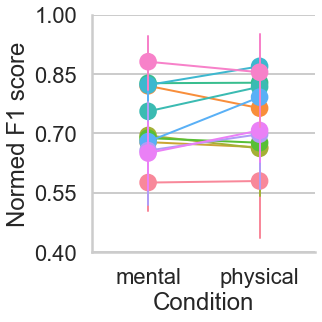

In [106]:
subject_means_by_condition = df.groupby(['gameID','condition']).mean()
condition_means = subject_means_by_condition.groupby('condition')['normedScore'].mean()

subject_scores_by_condition = subject_means_by_condition['normedScore']

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.catplot(x='condition', 
                y='normedScore', 
                hue='gameID', 
                kind='point', 
                legend=False,
                data=df);
plt.ylabel('Normed F1 score')
plt.xlabel('Condition')
plt.yticks(np.linspace(0.4,1,5))
plt.setp(c.ax.lines,linewidth=2)
plt.tight_layout()



In [6]:
score_condition = df_for_analysis[['condition','normedScore']]

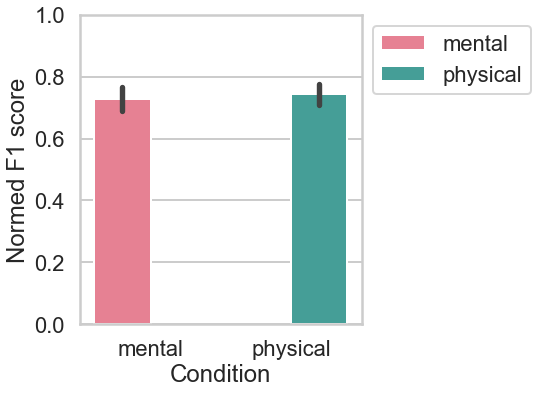

In [28]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
b = sns.barplot(data=score_condition,
                palette='husl',
                hue='condition',
                x='condition',
                y='normedScore')
plt.legend(bbox_to_anchor=(1.0,1))
plt.ylabel('Normed F1 score')
plt.xlabel('Condition')
plt.yticks(np.linspace(0,1,6))
plt.tight_layout()


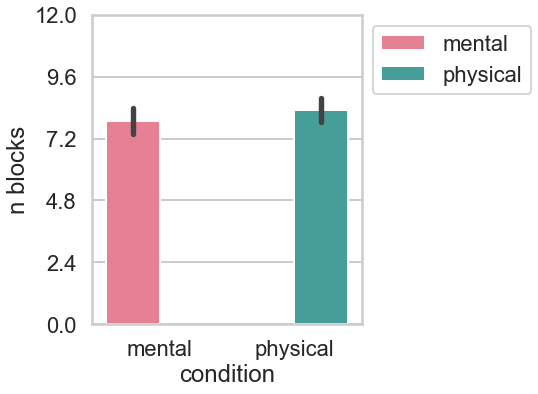

In [32]:
nblocks_condition = df_for_analysis[['condition','numBlocks']]

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
b = sns.barplot(data=nblocks_condition,
                palette='husl',
                hue='condition',
                x='condition',
                y='numBlocks')
plt.legend(bbox_to_anchor=(1.0,1))
plt.ylabel('n blocks')
plt.xlabel('condition')
plt.yticks(np.linspace(0,12,6))
plt.tight_layout()

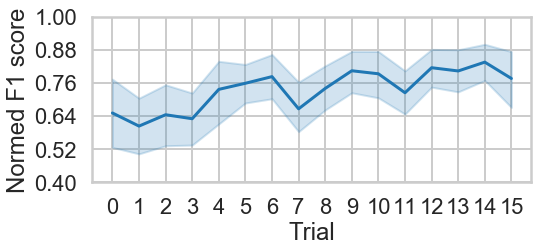

In [44]:
score_trials = df_for_analysis[['trialNum','normedScore']]

fig = plt.figure(figsize=(8,4))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
b = sns.lineplot(data=score_trials,
                palette='husl',
                x='trialNum',
                y='normedScore')
plt.ylabel('Normed F1 score')
plt.xlabel('Trial')
plt.yticks(np.linspace(0.4,1,6))
plt.xticks(np.linspace(0,15,16))
plt.tight_layout()